# Wikipedia Thanks-Receiver Study Randomization 
[J. Nathan Matias](https://twitter.com/natematias) + Max Klein
January 22, 2020

This code takes as input data described in the [randomization data format](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit?usp=drive_web&ouid=117701977297551627494) and produces randomizations for the Thanks Recipient study.

Notes:
* We use the 99% confidence interval cutoffs from our first sample rather than relative to each subsequent sample
    * Polish Experienced: 235.380736142341
    * Polish Newcomer: 72.2118047599678
    * Arabic Newcomer: 54.7365066602131
    * German Newcomer: 63.3678642498622

In [1]:
options("scipen"=9, "digits"=4)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(blockTools)
library(blockrand)
library(gmodels) # contains CrossTable
library(DeclareDesign)
library(DescTools) # contains Freq
library(uuid)
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.2.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::as_function() masks rlang::as_function()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::invoke()      masks rlang::invoke()
✖ dplyr::lag()         masks stats::lag()
✖ purrr::list_along()  masks rlang::list_along()
✖ purrr::modify()      masks rlang::modify()
✖ purrr::rep_along()   masks rlang::rep_along()
✖ purrr::splice()      masks rlang::spl

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] uuid_0.1-2           DescTools_0.99.28    DeclareDesign_0.12.0
 [4] estimatr_0.14        fabricatr_0.6.0      randomizr_0.16.1    
 [7] gmodels_2.18.1       blockrand_1.3        blockTools_0.6-3    
[10] viridis_0.5.1        viridisLite_0.3.0    forcats_0.3.0       
[13] stringr_1.3.1        dpl

# Load Input Dataframe

In [2]:
filename <- "all-thankees-historical-20200120.csv"
data.path <- "/home/civilservant/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thankee"
recipient.df <- read.csv(file.path(data.path, "historical_output", filename))

### Load Participants in the Thanker Study

In [3]:
# thankers file format no longer contains user names
thanker.df <- read.csv(file.path(data.path, "..", "thanker_hardlaunch", "definitive",
                                 "grat_thanker_account_mapping.csv"))
usernames.to.exclude <- thanker.df$user_name

###  Load Liaison Usernames

### Adjust Column Names to Match Thankee Randomization Specification

In [4]:
liaison.df <- read.csv(file.path(data.path, "..", "thanker_hardlaunch", "randomization_output",
                                 "liason-thanker-randomization-datadrill-20190718.csv"))

In [5]:
usernames.to.exclude <- append(as.character(usernames.to.exclude), as.character(liaison.df$user_name))
print(paste(length(usernames.to.exclude), "usernames to exclude"))

[1] "462 usernames to exclude"


In [6]:
recipient.df$prev_experience <- factor(as.integer(gsub("bin_", "", recipient.df$prev_experience)))
recipient.df$anonymized_id <- sapply( seq_along(1:nrow(recipient.df)), UUIDgenerate )
recipient.df$newcomer <- recipient.df$prev_experience == 0 
recipient.df <- subset(recipient.df, lang!="en")
#recipient.df <- subset(recipient.df, user_editcount_quality >=4 )

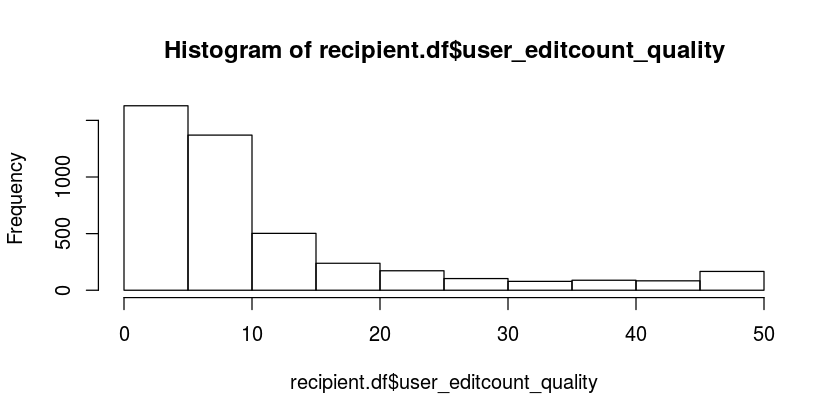

In [7]:
hist(recipient.df$user_editcount_quality)

# Confirm the number of participants

In [8]:
print("Newcomer Participants to Randomize")
summary(subset(recipient.df, newcomer == 1)$lang)

[1] "Newcomer Participants to Randomize"


ar   de   pl 
1236 2340  627

In [9]:
## Polish Experienced Accounts
print("Experienced Participants to Randomize")
summary(subset(recipient.df, newcomer == 0)$lang)

[1] "Experienced Participants to Randomize"


ar  de  pl 
  0   0 226

# Omit Participants

### Subset values outside the 99% confidence intervals
We are using upper confidence intervals from the first randomization, found at [generate-wikipedia-thanks-recipient-randomizations-final-07.28.3019](generate-wikipedia-thanks-recipient-randomizations-final-07.28.3019.R.ipynb)
    * Polish Experienced: 235.380736142341
    * Polish Newcomer: 72.2118047599678
    * Arabic Newcomer: 54.7365066602131
    * German Newcomer: 63.3678642498622

### Omit Participants in the Thanker Study

In [10]:
print(paste(nrow(recipient.df), "participants before removing thankers"))
recipient.df <- subset(recipient.df, (user_name %in% usernames.to.exclude)!=TRUE)
print(paste(nrow(recipient.df), "participants after removing thankers"))                                      

[1] "4429 participants before removing thankers"
[1] "4425 participants after removing thankers"


In [11]:
upper.conf.ints <- data.frame(lang=c("pl", "pl", "de", "ar"),
                              newcomer=c(0,1,1,1),
                              conf.int = c(
                                  235.380736142341,
                                  72.2118047599678,
                                  54.7365066602131,
                                  63.3678642498622
                              ))

In [12]:
upper.conf.ints
#subset(upper.conf.ints, lang=="pl" & newcomer ==1)$conf.int

lang,newcomer,conf.int
pl,0,235.38
pl,1,72.21
de,1,54.74
ar,1,63.37


In [13]:
## CREATE A PLACEHOLDER WITH ZERO ROWS
## BEFORE ITERATING
recipient.trimmed.df <- recipient.df[0,]

for(l in c("ar", "de", "fa", "pl")){
    print(paste("Language: ", l))
    for(n in c(0,1)){
        print(paste("  newcomer:", n == 1))
        lang.df <- subset(recipient.df, lang==l & newcomer == n)
        print(paste( "     ", nrow(lang.df), "rows from original dataset"))
        prev.conf.int <- subset(upper.conf.ints, lang==l & newcomer ==n)$conf.int

        print(      "      99% confidence intervals:")
        print(paste("          upper: ", prev.conf.int ,sep=""))
        
        print(paste("      Removing", 
            nrow(subset(lang.df,
                        labor_hours_84_days_pre_sample > prev.conf.int)), "outliers",
           "observations because labor_hours_84_days_pre_sample is an outlier."))
        lang.subset.df <- subset(lang.df, labor_hours_84_days_pre_sample <= prev.conf.int)
        print(paste( "     ", nrow(lang.subset.df), "rows in trimmed dataset"))
        recipient.trimmed.df <- rbind(recipient.trimmed.df, lang.subset.df)
    }
}

recipient.df.penultimate <- recipient.trimmed.df

[1] "Language:  ar"
[1] "  newcomer: FALSE"
[1] "      0 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: "
[1] "      Removing 0 outliers observations because labor_hours_84_days_pre_sample is an outlier."
[1] "      0 rows in trimmed dataset"
[1] "  newcomer: TRUE"
[1] "      1236 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: 63.3678642498622"
[1] "      Removing 19 outliers observations because labor_hours_84_days_pre_sample is an outlier."
[1] "      1217 rows in trimmed dataset"
[1] "Language:  de"
[1] "  newcomer: FALSE"
[1] "      0 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: "
[1] "      Removing 0 outliers observations because labor_hours_84_days_pre_sample is an outlier."
[1] "      0 rows in trimmed dataset"
[1] "  newcomer: TRUE"
[1] "      2336 rows from original dataset"
[1] "      99% confidence intervals:"
[1] "          upper: 54.7365066602131"
[

# Review and Generate Variables

In [14]:
print(aggregate(recipient.df.penultimate[c("labor_hours_84_days_pre_sample")],
          FUN=mean, by = list(recipient.df.penultimate$prev_experience)))

  Group.1 labor_hours_84_days_pre_sample
1       0                         3.2465
2      90                         0.9717
3     180                         8.4362
4     365                         2.4673
5     730                         6.5320
6    1460                         2.7131
7    2920                         3.0215


In [15]:
print(CrossTable(recipient.df.penultimate$has_email, recipient.df.penultimate$newcomer, 
       prop.r = FALSE, prop.c=TRUE, prop.t = FALSE, prop.chisq = FALSE))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  4340 

 
                                   | recipient.df.penultimate$newcomer 
recipient.df.penultimate$has_email |     FALSE |      TRUE | Row Total | 
-----------------------------------|-----------|-----------|-----------|
                             False |        15 |        36 |        51 | 
                                   |     0.066 |     0.009 |           | 
-----------------------------------|-----------|-----------|-----------|
                              True |       211 |      4078 |      4289 | 
                                   |     0.934 |     0.991 |           | 
-----------------------------------|-----------|-----------|-----------|
                      Column Total |       226 |      4114 |      4340 | 
                                   |     0.052 |     0.948 |           | 
-----------------

In [16]:
## Update the has_email field
## recipient.df.penultimate$has_email <- recipient.df.penultimate$has_email == "True"

## PREVIOUS EXPERIENCE
print("prev_experience")
print(summary(factor(recipient.df.penultimate$prev_experience)))
cat("\n")

## SHOW LABOR HOURS BY EXPERIENCE GROUP:
print("Aggregate labor_hours_84_days_pre_sample")
print(aggregate(recipient.df.penultimate[c("labor_hours_84_days_pre_sample")],
          FUN=mean, by = list(recipient.df.penultimate$prev_experience)))
cat("\n")

print("NEWCOMERS AND EMAILS")
print("--------------------")
print(CrossTable(recipient.df.penultimate$has_email, recipient.df.penultimate$newcomer, 
       prop.r = FALSE, prop.c=TRUE, prop.t = FALSE, prop.chisq = FALSE))

# VARIABLE: num_prev_thanks_pre_treatment
print("num_prev_thanks_pre_sample")
print(summary(recipient.df.penultimate$num_prev_thanks_pre_sample))
cat("\n")
    
## SHOW PREVIOUS THANKS BY EXPERIENCE GROUP:
print("num_prev_thanks_pre_sample by prev_experience")
print(aggregate(recipient.df.penultimate[c("num_prev_thanks_pre_sample")],
      FUN=mean, by = list(recipient.df.penultimate$prev_experience)))
cat("\n")

[1] "prev_experience"
   0   90  180  365  730 1460 2920 
4114    2   18   42   33   52   79 

[1] "Aggregate labor_hours_84_days_pre_sample"
  Group.1 labor_hours_84_days_pre_sample
1       0                         3.2465
2      90                         0.9717
3     180                         8.4362
4     365                         2.4673
5     730                         6.5320
6    1460                         2.7131
7    2920                         3.0215

[1] "NEWCOMERS AND EMAILS"
[1] "--------------------"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  4340 

 
                                   | recipient.df.penultimate$newcomer 
recipient.df.penultimate$has_email |     FALSE |      TRUE | Row Total | 
-----------------------------------|-----------|-----------|-----------|
                             False |        15 |        36 |        51 | 
        

# Subset Sample to Planned sample sizes
Sample sizes are reported in the experiment [Decisions Document](https://docs.google.com/document/d/1HryhsmWI6WthXQC7zv9Hz1a9DhpZ3FxVRLjTONuMg4I/edit)

* Arabic newcomers (1750 goal) (hoping for as many as possible in first sample)
    * hoping for 1350 in the first sample and 400 later
    * thanked 174.
    * we incude all 1236 round 3 newcomers
* German newcomers (3000 goal) (hoping for as many as possible in first sample)
    * hoping for 1600 in first sample and 1400 later
    * thanked 759. 
    * need to thank 750 more, accounting for 75% thank rate, including 2000 more round 3 newcomers
* Persian Experienced (2400 goal)
* Polish:
    * Newcomers: (800 goal)
    * thanked 74
    * including 626 (maximum available)
    * Experienced: (2400 goal)
    * thanked 1082
    * including 226 (maximum available)

In [17]:
## Seed generated by Brooklyn Integers
# https://www.brooklynintegers.com/int/1495265601/
set.seed(1495265601)

In [18]:
print("Newcomers")
summary(subset(recipient.df.penultimate, newcomer==1)$lang)

[1] "Newcomers"


ar   de   pl 
1217 2271  626

In [19]:
print("Experienced")
summary(subset(recipient.df.penultimate, newcomer==0)$lang)

[1] "Experienced"


ar  de  pl 
  0   0 226

In [20]:
## CREATE THE FINAL PARTICIPANT SAMPLE BEFORE RANDOMIZATION
recipient.df.final <- recipient.df.penultimate

# Generate Randomization Blocks

In [21]:
recipient.df.final$lang_prev_experience <- factor(paste(recipient.df.final$lang, recipient.df.final$prev_experience))
colnames(recipient.df.final)

[1] "id"                             "created_at"                    
 [3] "lang"                           "user_id"                       
 [5] "user_name"                      "user_registration"             
 [7] "user_editcount"                 "user_editcount_quality"        
 [9] "prev_experience"                "thanks_sent"                   
[11] "num_prev_thanks"                "num_prev_thanks_90"            
[13] "num_prev_thanks_pre_sample"     "labor_hours_84_days_pre_sample"
[15] "has_email"                      "user_completed"                
[17] "user_included"                  "anonymized_id"                 
[19] "newcomer"                       "lang_prev_experience"

In [22]:
## BLOCKING VARIABLES
bv = c("labor_hours_84_days_pre_sample", "num_prev_thanks_pre_sample")

block.size = 2

## TODO: CHECK TO SEE IF I CAN DO BALANCED RANDOMIZATION
## WITHIN BLOCKS LARGER THAN 2
blockobj = block(data=recipient.df.final,
            n.tr = block.size,
            groups = "lang_prev_experience",
            id.vars="anonymized_id",
            block.vars = bv,
            distance ="mahalanobis"
            )
## CHECK DISTANCES
#print(blockobj)
recipient.df.final$randomization_block_id <- createBlockIDs(blockobj,
                                   data=recipient.df.final,
                                   id.var = "anonymized_id")
recipient.df.final$randomization_block_size = block.size

### Identify Incomplete Blocks and Remove Participants in Incomplete Blocks From the Experiment

In [23]:
block.sizes <- aggregate(recipient.df.final$randomization_block_id, FUN=length, by=list(recipient.df.final$randomization_block_id))
incomplete.blocks <- subset(block.sizes, x == 1)$Group.1
incomplete.blocks

[1]  609 1745 2133 2171

In [24]:
nrow(subset(recipient.df.final, randomization_block_id %in% incomplete.blocks))

[1] 4

In [25]:
removed.observations <- subset(recipient.df.final, (
    randomization_block_id %in% incomplete.blocks)==TRUE)

recipient.df.final <- 
    subset(recipient.df.final, (
        randomization_block_id %in% incomplete.blocks)!=TRUE)

print(paste("Removed", nrow(removed.observations), "units placed in incomplete blocks."))

[1] "Removed 4 units placed in incomplete blocks."


# Generate Randomizations

In [26]:
assignments <- block_ra(blocks=recipient.df.final$randomization_block_id, 
                            num_arms = 2, conditions = c(0,1))
recipient.df.final$randomization_arm <- assignments 

### Check Balance

In [27]:
print("Aggregating labor hours by treatment")
print(aggregate(recipient.df.final[c("labor_hours_84_days_pre_sample")],
          FUN=mean, by = list(recipient.df.final$randomization_arm)))

print("CrossTable of lang by treatment")
CrossTable(recipient.df.final$lang, recipient.df.final$randomization_arm, 
       prop.r = TRUE, prop.c=FALSE, prop.t = FALSE, prop.chisq = FALSE)

print("CrossTable of lang_prev_experience by treatment")
CrossTable(recipient.df.final$lang_prev_experience, recipient.df.final$randomization_arm, 
       prop.r = TRUE, prop.c=FALSE, prop.t = FALSE, prop.chisq = FALSE)


[1] "Aggregating labor hours by treatment"
  Group.1 labor_hours_84_days_pre_sample
1       0                           3.24
2       1                           3.18
[1] "CrossTable of lang by treatment"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  4336 

 
                        | recipient.df.final$randomization_arm 
recipient.df.final$lang |         0 |         1 | Row Total | 
------------------------|-----------|-----------|-----------|
                     ar |       608 |       608 |      1216 | 
                        |     0.500 |     0.500 |     0.280 | 
------------------------|-----------|-----------|-----------|
                     de |      1135 |      1135 |      2270 | 
                        |     0.500 |     0.500 |     0.524 | 
------------------------|-----------|-----------|-----------|
                     pl |       425 |       425 |       8

# Subset German Newcomers Accounts
Within German, identify 2000 accounts (1000 blocks) to include and drop all of the others.

In [28]:
length(subset(recipient.df.penultimate, lang=='de')$prev_experience)

[1] 2271

In [29]:
## SHOW PREVIOUS THANKS BY EXPERIENCE GROUP:
recipient.df.final$count.var <- 1
print("Number of Accounts for each experience level among German Participants")
print(aggregate(subset(recipient.df.final, lang=="de")[c("count.var")],
      FUN=sum, by = list(subset(recipient.df.final, lang=="de")$prev_experience)))
cat("\n")

[1] "Number of Accounts for each experience level among German Participants"
  Group.1 count.var
1       0      2270



In [30]:
num.de.blocks.target <- 1000

included.de.blocks.df <-
recipient.df.final %>% 
subset(lang=='de') %>% 
select(randomization_block_id) %>% 
unique() %>% 
sample_n(num.de.blocks.target)

included.pl.blocks.df <-
recipient.df.final %>% 
subset(lang=='pl') %>% 
select(randomization_block_id) %>% 
unique()

included.ar.blocks.df <-
recipient.df.final %>% 
subset(lang=='ar') %>% 
select(randomization_block_id) %>% 
unique()

included.de.blocks <- included.de.blocks.df$randomization_block_id
included.pl.blocks <- included.pl.blocks.df$randomization_block_id
included.ar.blocks <- included.ar.blocks.df$randomization_block_id


included.blocks <- c(included.de.blocks, included.pl.blocks, included.ar.blocks)

In [31]:
total.blocks.pre.subset <- recipient.df.final %>% select(randomization_block_id) %>% unique %>% nrow
total.blocks.post.subset <- included.blocks %>% length
expected.block.deduction <- 1000 - recipient.df.final %>%  subset(lang=='de') %>%  select(randomization_block_id) %>%  unique() %>% nrow
print("Blocks before subsetting")
print(total.blocks.pre.subset)
print("Blocks after subsetting")
print(total.blocks.post.subset)
print("Expected blocks deduction")
print(expected.block.deduction)
print("Assert valid")
print(total.blocks.pre.subset + expected.block.deduction == total.blocks.post.subset)


[1] "Blocks before subsetting"
[1] 2168
[1] "Blocks after subsetting"
[1] 2033
[1] "Expected blocks deduction"
[1] -135
[1] "Assert valid"
[1] TRUE


In [32]:
recipient.df.final.included <- recipient.df.final %>% filter(randomization_block_id %in% included.blocks)

In [33]:
print('Included users before subsetting')
print(nrow(recipient.df.final))
print("Included users after subsetting")
print(nrow(recipient.df.final.included))

[1] "Included users before subsetting"
[1] 4336
[1] "Included users after subsetting"
[1] 4066


### Offset block IDs to be unique
Observe the block IDs from the previous randomizations and ensure that these ones are unique and larger.

In [34]:
## LOAD PREVIOUS RANDOMIZATIONS
prev_randomization_filename <- "thanks-recipient-randomizations-20191029.csv"
prev.randomization.df <- read.csv(file.path(data.path, "randomization_output", prev_randomization_filename))
print(paste("Max Block ID: ", max(prev.randomization.df$randomization_block_id)))
prev.max.block.id <- max(prev.randomization.df$randomization_block_id)

[1] "Max Block ID:  5827"


In [35]:
prev.max.block.id <- 5827

In [36]:
# recipient.df.final.included$initial.block.id <- NA

In [37]:
recipient.df.final.included$initial.block.id <- recipient.df.final.included$randomization_block_id

In [38]:
recipient.df.final.included$randomization_block_id <- recipient.df.final.included$initial.block.id + prev.max.block.id
# summary(recipient.df.final.included$randomization_block_id)

In [39]:
recipient.df.final.included

id,created_at,lang,user_id,user_name,user_registration,user_editcount,user_editcount_quality,prev_experience,thanks_sent,⋯,user_completed,user_included,anonymized_id,newcomer,lang_prev_experience,randomization_block_id,randomization_block_size,randomization_arm,count.var,initial.block.id
67747,2020-01-20T14:57:09,ar,1576994,Mr.dagbashey,2018-10-27T00:11:36,19,4,0,NA,⋯,False,True,42994612-7a0f-4078-86d4-778e91d54216,TRUE,ar 0,5987,2,0,1,160
67749,2020-01-20T14:57:09,ar,1577265,TheTrueGilben,2018-10-27T14:19:06,23,5,0,NA,⋯,False,True,2db3f3ae-26dc-4e82-b221-065eab7cadc7,TRUE,ar 0,6312,2,1,1,485
67751,2020-01-20T14:57:09,ar,1578065,Lara Ehwait,2018-10-28T20:20:37,6,6,0,NA,⋯,False,True,5f996a6b-90d1-4829-83dd-17ac82d304b2,TRUE,ar 0,5852,2,1,1,25
67755,2020-01-20T14:57:10,ar,1579150,Saadbarri,2018-10-30T18:56:04,7,7,0,NA,⋯,False,True,7d2e9764-dbe4-4f8c-8262-af53fc0415e8,TRUE,ar 0,6224,2,1,1,397
67759,2020-01-20T14:57:10,ar,1580146,Gerges6,2018-11-01T16:58:57,21,4,0,NA,⋯,False,True,4e761f26-636a-4d2c-b9d1-f04c864ff313,TRUE,ar 0,6247,2,0,1,420
67760,2020-01-20T14:57:10,ar,1580237,ابو حلب1020,2018-11-01T20:37:14,11,5,0,NA,⋯,False,True,c298fc95-c186-488d-9052-69622226e6d5,TRUE,ar 0,6105,2,0,1,278
67763,2020-01-20T14:57:10,ar,1581160,Sherif.Othman1,2018-11-03T17:11:07,27,19,0,NA,⋯,False,True,a3605357-a9ed-45b3-902a-a393899f5259,TRUE,ar 0,6408,2,0,1,581
67768,2020-01-20T14:57:10,ar,1583064,Saudi 238,2018-11-06T21:25:58,14,4,0,NA,⋯,False,True,57ea38e2-ad0f-4121-a9df-b266f90e8cec,TRUE,ar 0,6122,2,0,1,295
67770,2020-01-20T14:57:10,ar,1584050,Nagham jamjoom,2018-11-08T18:01:23,70,35,0,NA,⋯,False,True,b134690d-9798-4ef0-8f5d-aad34507b200,TRUE,ar 0,6413,2,0,1,586
67772,2020-01-20T14:57:10,ar,1584435,دانا عبد العزيز الجعبري,2018-11-09T12:30:30,80,33,0,NA,⋯,False,True,455a3eeb-f6a8-424c-829e-49f6af98bc8e,TRUE,ar 0,6371,2,1,1,544


### Sort by block ID

In [40]:
recipient.df.final.included <- recipient.df.final.included[order(recipient.df.final.included$randomization_block_id),]

In [42]:
print("Newcomers")
summary(subset(recipient.df.final.included, newcomer==1)$lang)
print("Experienced")
summary(subset(recipient.df.final.included, newcomer==0)$lang)

[1] "Newcomers"


ar   de   pl 
1216 2000  626

[1] "Experienced"


ar  de  pl 
  0   0 224

# Output and Archive Randomizations

In [44]:
randomization.filename <- paste("thanks-recipient-randomizations-", format(Sys.Date(), format="%Y%m%d"), ".csv", sep="") 
write.csv(recipient.df.final.included, file = file.path(data.path, "randomization_output", randomization.filename))

In [45]:
colnames(recipient.df.final.included)

[1] "id"                             "created_at"                    
 [3] "lang"                           "user_id"                       
 [5] "user_name"                      "user_registration"             
 [7] "user_editcount"                 "user_editcount_quality"        
 [9] "prev_experience"                "thanks_sent"                   
[11] "num_prev_thanks"                "num_prev_thanks_90"            
[13] "num_prev_thanks_pre_sample"     "labor_hours_84_days_pre_sample"
[15] "has_email"                      "user_completed"                
[17] "user_included"                  "anonymized_id"                 
[19] "newcomer"                       "lang_prev_experience"          
[21] "randomization_block_id"         "randomization_block_size"      
[23] "randomization_arm"              "count.var"                     
[25] "initial.block.id"